**Import libraries:**

In [1]:
# Import libraries
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import helper_utils

Set device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"USING DEVICE: {device}")

USING DEVICE: cpu


Download Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [4]:
dir = "./data"
train_data = torchvision.datasets.MNIST(
    root=dir,
    train=True,
    download=True,
    transform=transform
)

In [5]:
dir = "./data"
test_data = torchvision.datasets.MNIST(
    root=dir,
    train=False,
    download=True,
    transform=transform
)

In [6]:
# Create a dataloader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

Build Model:

In [7]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten_layer = nn.Flatten()
        self.linear_layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten_layer(x)
        x = self.linear_layers(x)
        return x

In [8]:
# Define Model, Loss function, Optimizer
model = MNISTClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_epoch(model, loss_function, optimizer, train_loader, device):

    model.to(device)
    model.train()

    epoch_loss = 0
    total_predictions = 0
    total_correct_predictions = 0
    total_size = len(train_loader)


    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()

        _, correct_index = outputs.max(1)

        total_predictions += len(outputs)
        total_correct_predictions += targets.eq(correct_index).sum().item()

    average_epoch_loss = epoch_loss / total_size
    accuracy = (100 * total_correct_predictions) / total_predictions

    return average_epoch_loss, accuracy

In [10]:
def test_epoch(model, loss_function, test_loader, device):
    model.to(device)
    model.eval()

    epoch_loss = 0

    total_predictions = 0
    total_correct_predictions = 0
    total_size = len(test_loader)

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            epoch_loss += loss.item()
            total_predictions += len(outputs)
            _, correct_index = outputs.max(1)
            total_correct_predictions += targets.eq(correct_index).sum().item()

        average_epoch_loss = epoch_loss / total_size
        accuracy = (total_correct_predictions * 100) / total_predictions


        return average_epoch_loss, accuracy

In [11]:
EPOCHS = 10
train_loss_history = []
test_loss_history = []


pbar = tqdm(range(EPOCHS), desc="Training", unit="epoch")

for epoch in pbar:
    train_loss, train_acc = train_epoch(
        model, loss_function, optimizer, train_loader, device
    )
    test_loss, test_acc = test_epoch(
        model, loss_function, test_loader, device
    )

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    pbar.set_postfix({
        "TrainLoss": f"{train_loss:.4f}",
        "TrainAcc":  f"{train_acc:.2f}%",
        "TestLoss":  f"{test_loss:.4f}",
        "TestAcc":   f"{test_acc:.2f}%"
    })



Training: 100%|██████████| 10/10 [02:05<00:00, 12.52s/epoch, TrainLoss=0.0261, TrainAcc=99.13%, TestLoss=0.1083, TestAcc=97.63%]


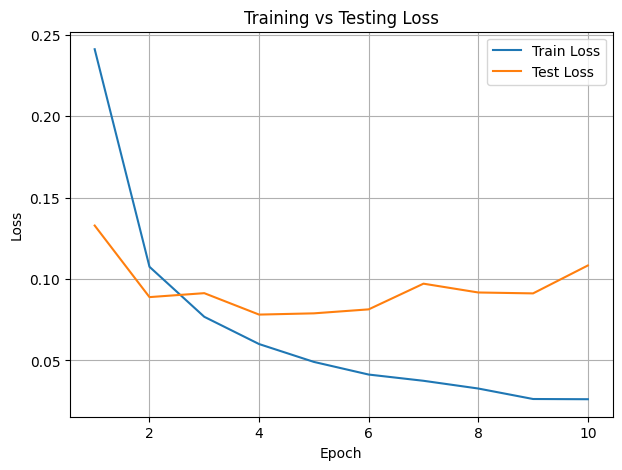

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, test_loss_history, label="Test Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
plt.show()